In [1]:
import sys
# if kernel_mode:
#     sys.path.insert(0, "../input/iterative-stratification")

import os
import numpy as np
import pandas as pd
import time
import random
import math

import matplotlib
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.manifold import TSNE

import seaborn as sns
sns.set(style="darkgrid")

import gc
gc.enable()

rand_seed = 1120
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [2]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect


class DeepInsightTransformer:
    """Transform features to an image matrix using dimensionality reduction

    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix

    """
    def __init__(self,
                 feature_extractor='tsne',
                 perplexity=30,
                 pixels=100,
                 random_state=None,
                 n_jobs=None):
        """Generate an ImageTransformer instance

        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne_exact'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='exact',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'tsne'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='barnes_hut',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2, random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(n_components=2,
                               kernel='rbf',
                               random_state=self.random_state,
                               n_jobs=self.n_jobs)
            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)

        # The resolution of transformed image
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y=None, plot=False):
        """Train the image transformer from the training set (X)

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle

        Returns:
            self: object
        """
        # Transpose to get (n_features, n_samples)
        X = X.T

        # Perform dimensionality reduction
        x_new = self._fe.fit_transform(X)

        # Get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]

        # Determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)

        # Rotate the matrix
        # Save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T

        # Determine feature coordinates based on pixel dimension
        self._calculate_coords()

        # plot rotation diagram if requested
        if plot is True:
            # Create subplots
            fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
            ax[0, 0].scatter(x_new[:, 0],
                             x_new[:, 1],
                             cmap=plt.cm.get_cmap("jet", 10),
                             marker="x",
                             alpha=1.0)
            ax[0, 0].fill(x_new[chvertices, 0],
                          x_new[chvertices, 1],
                          edgecolor='r',
                          fill=False)
            ax[0, 0].fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        """The image matrix dimensions

        Returns:
            tuple: the image matrix dimensions (height, width)

        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension

        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix

        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(self._xrot[:, 0],
                                bins=np.linspace(min(self._xrot[:, 0]),
                                                 max(self._xrot[:, 0]),
                                                 self._pixels[0])) - 1
        ax1_coord = np.digitize(self._xrot[:, 1],
                                bins=np.linspace(min(self._xrot[:, 1]),
                                                 max(self._xrot[:, 1]),
                                                 self._pixels[1])) - 1
        self._coords = np.stack((ax0_coord, ax1_coord))

    def transform(self, X, empty_value=0):
        """Transform the input matrix into image matrices

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """

        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        img_coords = pd.DataFrame(np.vstack(
            (self._coords, X.clip(0, 1))).T).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        return img_matrices

    def fit_transform(self, X, empty_value=0):
        """Train the image transformer from the training set (X) and return
        the transformed data.

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform(X, empty_value=empty_value)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel

        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        coord_cnt = (
            pd.DataFrame(self._coords.T).assign(count=1).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).count())
        fdmat[coord_cnt[0].astype(int),
              coord_cnt[1].astype(int)] = coord_cnt['count']
        return fdmat

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.

        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.

        Args:
            hull_points : an nx2 matrix of hull coordinates

        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2.

        # Calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)

        # Find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            np.cos(angles - pi2),
            np.cos(angles + pi2),
            np.cos(angles)
        ]).T
        rotations = rotations.reshape((-1, 2, 2))

        # Apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)

        # Find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)

        # Find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)

        # Return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]

        # Generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

In [3]:
def plot_embed_2D(X, title=None):
    sns.set(style="darkgrid")

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
    ax[0, 0].scatter(X[:, 0],
                     X[:, 1],
                     cmap=plt.cm.get_cmap("jet", 10),
                     marker="x",
                     alpha=1.0)
    plt.gca().set_aspect('equal', adjustable='box')

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()


def tsne_transform(data, perplexity=30, plot=True):
    # Transpose to get (n_features, n_samples)
    data = data.T

    tsne = TSNE(n_components=2,
                metric='cosine',
                perplexity=perplexity,
                n_iter=1000,
                method='exact',
                random_state=rand_seed,
                n_jobs=-1)
    # Transpose to get (n_features, n_samples)
    transformed = tsne.fit_transform(data)

    if plot:
        plot_embed_2D(
            transformed,
            f"All Feature Location Matrix of Training Set (Perplexity: {perplexity})"
        )
    return transformed

class LogScaler:
    """Log normalize and scale data

    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    
    Note: The dimensions of input matrix is (N samples, d features)
    """
    def __init__(self):
        self._min0 = None
        self._max = None

    """
    Use this as a preprocessing step in inference mode.
    """
    def fit(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

    """
    For training set only.
    """
    def fit_transform(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

    """
    For validation and test set only.
    """
    def transform(self, X, y=None):
        # Adjust min. of each feature of X by _min0
        for i in range(X.shape[1]):
            X[:, i] = X[:, i].clip(min=self._min0[i], max=None)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

In [4]:
X, y = load_breast_cancer(return_X_y=True)
# X = X.reshape(-1, 30, 1)
# y = to_categorical(y.reshape(-1, 1))
# featurewiseな標準化
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [5]:
X_train.shape

(398, 30)

In [6]:
all_scaler = LogScaler()
train_all_features = all_scaler.fit_transform(X_train)
# valid_all_features = all_scaler.transform(valid_all_features)
test_all_features = all_scaler.transform(X_test)

In [10]:
train_all_features

array([[0.35350863, 0.38469034, 0.56882763, ..., 0.00853474, 0.04429116,
        0.01631376],
       [0.34723078, 0.40224898, 0.56145674, ..., 0.00752968, 0.03816036,
        0.01491642],
       [0.35806779, 0.39949652, 0.57304257, ..., 0.00939611, 0.04569468,
        0.01522068],
       ...,
       [0.34023482, 0.40106542, 0.55370176, ..., 0.00586837, 0.04022507,
        0.01522487],
       [0.3421607 , 0.40065455, 0.55473306, ..., 0.        , 0.03550377,
        0.01356095],
       [0.35363087, 0.42210254, 0.56935774, ..., 0.01097233, 0.0372843 ,
        0.01584771]])

In [ ]:
train_all_tsne = tsne_transform(train_all_features, perplexity=5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


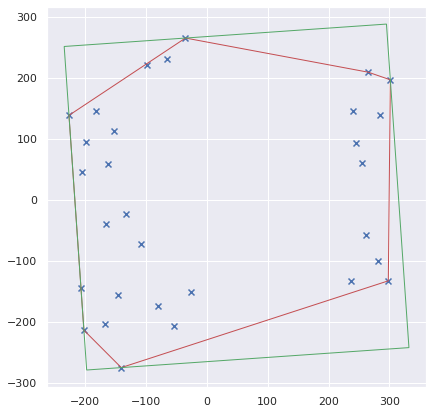

In [13]:
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=100,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)

all_it.fit(train_all_features, plot=True)

In [14]:
# all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
#                                 pixels=100,
#                                 perplexity=5,
#                                 random_state=rand_seed,
#                                 n_jobs=-1)
# all_it.fit(pd.DataFrame(X_train).values, plot=True)

In [15]:
# Plot image matrix with feature counts per pixel
def plot_feature_density(it, pixels=100, show_grid=True, title=None):
    # Update image size
    it.pixels = pixels

    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)

    if show_grid:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0.01,
                    linecolor="lightgrey",
                    square=False,
                    ax=ax[0, 0])
        for _, spine in ax[0, 0].spines.items():
            spine.set_visible(True)
    else:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0,
                    square=False,
                    ax=ax[0, 0])

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()

    # Feature Overlapping Counts
    gene_overlap = (
        pd.DataFrame(all_it._coords.T).assign(count=1).groupby(
            [0, 1],  # (x1, y1)
            as_index=False).count())
    print(gene_overlap["count"].describe())
    print(gene_overlap["count"].hist())
    plt.suptitle("Feauture Overlap Counts")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


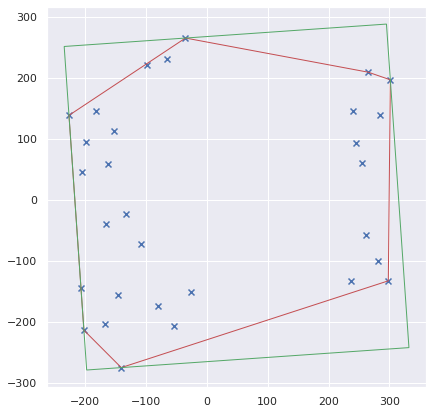

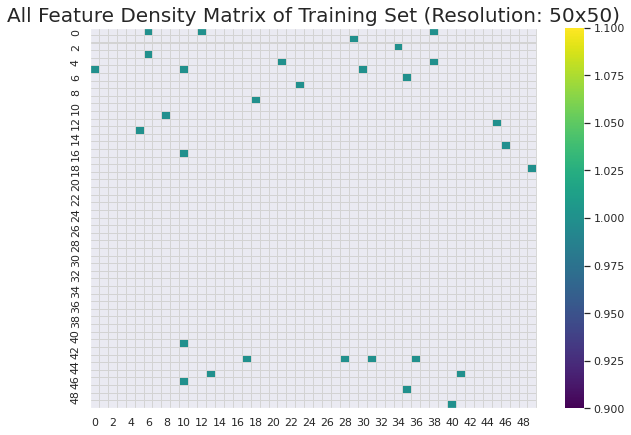

count    30.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: count, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


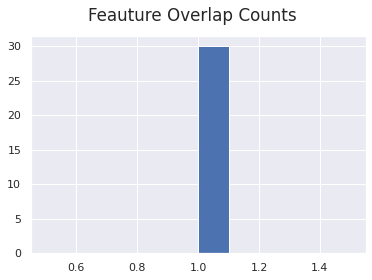

In [138]:
resolution = 50
# all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
#                                 pixels=resolution,
#                                 perplexity=50,
#                                 random_state=rand_seed,
#                                 n_jobs=-1)
# all_it.fit(pd.DataFrame(X_train).values, plot=True)
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=50,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=True)

plot_feature_density(
    all_it,
    pixels=resolution,
    title=
    f"All Feature Density Matrix of Training Set (Resolution: {resolution}x{resolution})"
)

In [17]:
trans_imgs = all_it.transform(train_all_features)
val_imgs = all_it.transform(test_all_features)

In [27]:
len(trans_imgs), trans_imgs[0].shape

(398, (50, 50))

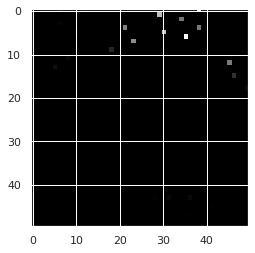

In [19]:
plt.imshow(trans_imgs[0], cmap='gray')

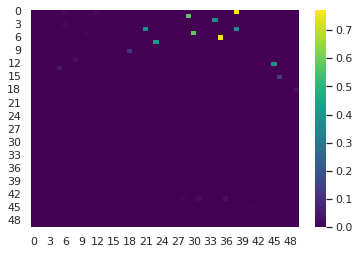

In [22]:
sns.heatmap(trans_imgs[0],
            cmap="viridis",
            linewidths=0,
            square=False)

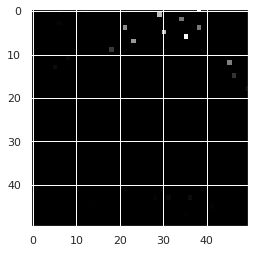

In [29]:
plt.imshow(trans_imgs[397], cmap='gray')

In [54]:
trans_imgs[0].shape

(50, 50)

In [63]:
pd.DataFrame(y_test).values.reshape(-1,1).shape

(171, 1)

In [130]:
train_all_features

array([[0.35350863, 0.38469034, 0.56882763, ..., 0.00853474, 0.04429116,
        0.01631376],
       [0.34723078, 0.40224898, 0.56145674, ..., 0.00752968, 0.03816036,
        0.01491642],
       [0.35806779, 0.39949652, 0.57304257, ..., 0.00939611, 0.04569468,
        0.01522068],
       ...,
       [0.34023482, 0.40106542, 0.55370176, ..., 0.00586837, 0.04022507,
        0.01522487],
       [0.3421607 , 0.40065455, 0.55473306, ..., 0.        , 0.03550377,
        0.01356095],
       [0.35363087, 0.42210254, 0.56935774, ..., 0.01097233, 0.0372843 ,
        0.01584771]])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


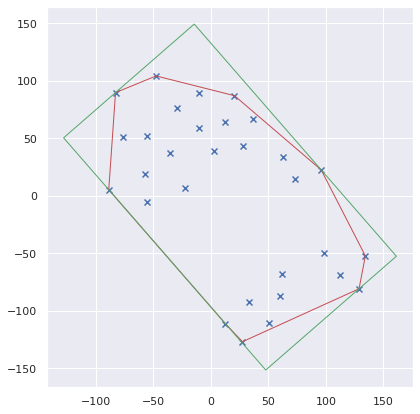

((398, 1, 20, 20), (398,))

In [223]:
X, y = load_breast_cancer(return_X_y=True)
# X = X.reshape(-1, 30, 1)
# y = to_categorical(y.reshape(-1, 1))
# featurewiseな標準化
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

all_scaler = LogScaler()
train_all_features = all_scaler.fit_transform(X_train)
test_all_features = all_scaler.transform(X_test)


resolution = 20
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=resolution,
                                perplexity=10,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=True)

trans_imgs = all_it.transform(train_all_features, empty_value=0)
val_imgs = all_it.transform(test_all_features, empty_value=0)

trans_imgs = np.array(trans_imgs).reshape(len(trans_imgs), -1, resolution, resolution)
val_imgs = np.array(val_imgs).reshape(len(val_imgs), -1, resolution, resolution)

trans_imgs.shape, y_train.shape

In [160]:
pd.DataFrame(np.ravel(trans_imgs[0] - trans_imgs[3])).describe()

,0
count,2500.000000
mean,-0.000176
std,0.003559
min,-0.106279
25%,0.000000
50%,0.000000
75%,0.000000
max,0.037959


In [195]:
y_train

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,

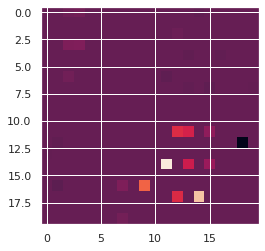

In [224]:
plt.imshow(trans_imgs[3][0] - trans_imgs[0][0])

In [ ]:
plt.imshow(trans_imgs[0][0])
plt.imshow(trans_imgs[3][0])


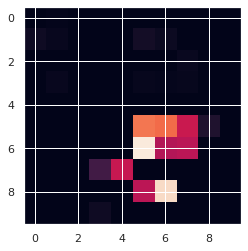

In [197]:
plt.imshow(trans_imgs[3][0])

In [261]:
import torch

BATCH_SIZE = 4
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 0.0001
EPOCH = 100

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

from torch.utils.data import DataLoader,TensorDataset

train_tensor_dset = TensorDataset(
    torch.tensor(trans_imgs, dtype=torch.float),
    torch.tensor(pd.DataFrame(y_train).values.reshape(-1,1), dtype=torch.float)
)

valid_tensor_dset = TensorDataset(
    torch.tensor(val_imgs, dtype=torch.float),
    torch.tensor(pd.DataFrame(y_test).values.reshape(-1,1), dtype=torch.float)
)

trainloader = torch.utils.data.DataLoader(train_tensor_dset, batch_size = BATCH_SIZE,
                        shuffle = True, num_workers = 1)

testloader = torch.utils.data.DataLoader(valid_tensor_dset, batch_size = BATCH_SIZE,
                        shuffle = False, num_workers = 1) 


In [262]:
train_tensor_dset.__getitem__(0)[0].size()

torch.Size([1, 20, 20])

In [280]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt  
class Net(nn.Module):
    def __init__(self, dropout_input):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout1 = nn.Dropout(dropout_input)
        self.conv1 = nn.Conv2d(1,16,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,48,3)

        # self.fc1 = nn.Linear(32 * 5 * 5, 120)
        # self.fc1 = nn.Linear(3872, 120)
        # self.fc1 = nn.Linear(32, 120)
        # self.fc1 = nn.Linear(288, 120)
        self.fc1 = nn.Linear(1296, 48)
        # self.fc2 = nn.Linear(120, 1)
        self.fc2 = nn.Linear(48, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout1(x)
        # x = self.conv2(x)
        # x = self.relu(x)
        # x = self.pool(x)
        # x = self.dropout1(x)
        # x = self.conv3(x)
        # x = self.relu(x)
        # x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

device = torch.device("cuda:0")
net = Net(dropout_input=0.1)
# net = ConvNeuralNet(1)
net = net.to(device)
# criterion = nn.CrossEntropyLoss()

criterion =  nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.5, weight_decay=WEIGHT_DECAY)
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)



In [ ]:
from sklearn.metrics import roc_auc_score

train_loss_value=[]      #trainingのlossを保持するlist
train_auc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_auc_value=[]        #testのaccuracyを保持するlist 

train_auc =[]
for epoch in range(EPOCH):
    train_auc_out=[]
    train_auc_label=[]
    val_auc_out=[]
    val_auc_label=[]
    print('epoch', epoch+1)    #epoch数の出力
    sum_loss = 0.0

    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()                            #lossを足していく
        train_auc_out.append(outputs)   #traindataのaccuracyをグラフ描画のためにlistに保持
        train_auc_label.append(labels)   #traindataのaccuracyをグラフ描画のためにlistに保持

    y_hat = torch.cat([val for val in train_auc_out], dim=0)
    y = torch.cat([val for val in train_auc_label], dim=0)
    y_probs = torch.sigmoid(y_hat).detach().cpu().numpy()
    metric = roc_auc_score(y.cpu().numpy(), y_probs)
    print("train mean loss={}, AUC={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), metric))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_auc_value.append(metric)
  
    sum_loss = 0.0
    #test dataを使ってテストをする
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # inputs, labels = inputs, labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        sum_loss += loss.item()
        train_auc_out.append(outputs)   #traindataのaccuracyをグラフ描画のためにlistに保持
        train_auc_label.append(labels)   #traindataのaccuracyをグラフ描画のためにlistに保持
    y_hat = torch.cat([val for val in train_auc_out], dim=0)
    y = torch.cat([val for val in train_auc_label], dim=0)
    y_probs = torch.sigmoid(y_hat).detach().cpu().numpy()
    metric = roc_auc_score(y.cpu().numpy(), y_probs)
    print("test  mean loss={}, AUC={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), metric))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_auc_value.append(metric)

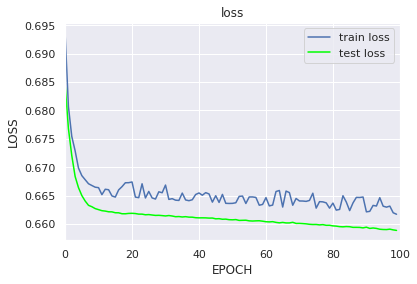

In [284]:
#以下グラフ描画
plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
# plt.savefig("loss_image.png")
# plt.clf()
plt.show()

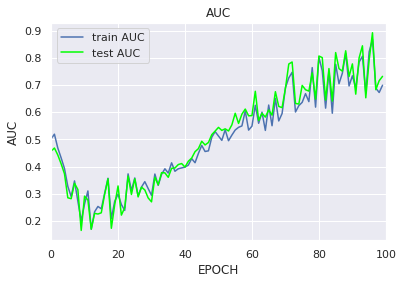

In [286]:
#以下グラフ描画
plt.plot(range(EPOCH), train_auc_value)
plt.plot(range(EPOCH), test_auc_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('AUC')
plt.legend(['train AUC', 'test AUC'])
plt.title('AUC')
# plt.savefig("loss_image.png")
# plt.clf()
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt    #グラフ出力用module

BATCH_SIZE = 100
WEIGHT_DECAY = 0.005
LEARNING_RATE = 0.0001
EPOCH = 100
PATH = "Datasetのディレクトリpath"

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root = PATH, train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE,
                        shuffle = True, num_workers = 1) #Windows Osの方はnum_workers=1 または 0が良いかも

testset = torchvision.datasets.MNIST(root = PATH, train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE,
                        shuffle = False, num_workers = 1) #Windows Osの方はnum_workers=1 または 0が良いかも

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,32,3)

        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda:0")
net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #testのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
    print("train mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    #test dataを使ってテストをする
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
    print("test  mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

plt.figure(figsize=(6,6))      #グラフ描画用

#以下グラフ描画
plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")
plt.clf()

plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
plt.ylim(0, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")

In [46]:
trainset.__getitem__(0)[0].dim()

3

In [47]:
trainset.__getitem__(0)[0].size()

torch.Size([1, 28, 28])

In [50]:
train_tensor_dset.__getitem__(0)[0].dim()

2

In [51]:
train_tensor_dset.__getitem__(0)[0].size()

torch.Size([50, 50])